In [23]:
import pandas as pd
import sklearn.metrics as metrique
import numpy as np
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Embedding, Dropout, Input, Concatenate, Permute, Dot, Multiply, Flatten,
    RepeatVector, Activation, Lambda
)
from tensorflow.keras import backend as K, regularizers, metrics

# Fix the cast import
from tensorflow.keras.backend import cast  


In [24]:
data = pd.read_csv('C:/Users/Admin/Desktop/creditcard.csv', na_filter=True)
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [25]:
tr_data = data.drop(col_del,axis =1)
tr_data.shape

(284807, 10)

In [26]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [27]:
# Generate and plot imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(tr_data['Class'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(tr_data['Class'] == label)[0]

Counter({0: 284315, 1: 492})


In [28]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]

Counter({0: 284315, 1: 284315})


In [29]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.3)

In [31]:
X_train.shape

(398041, 9)

In [32]:
X_test.shape

(170589, 9)

In [33]:
# design network
np.random.seed(7)

# X_train et X_val sont des dataframe qui contient les features
train_LSTM_X=X_train
val_LSTM_X=X_test

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y=y_train
val_LSTM_y=y_test

In [35]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

inputs = Input((1, 9))  
x1 = LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(inputs)  # Keep 3D output  
x2 = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(x1)  # Now it gets correct input  
outputs = Dense(1, activation='sigmoid')(x2)  
model = Model(inputs, outputs)

model.summary()  # Check model architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 50)               │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,251 (125.98 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Input, LSTM, Dense

# 🔹 Define Fixed Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="glorot_uniform")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-2], 1), initializer="zeros")        
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.linalg.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(Attention, self).get_config()
        return config


# 🔹 Define Model with Attention
inputs1 = Input((1, 9))
att_in = LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(inputs1)
att_in_1 = LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(att_in)
att_out = Attention()(att_in_1)  # Fixed class name capitalization
outputs1 = Dense(1, activation='sigmoid', trainable=True)(att_out)

model1 = Model(inputs1, outputs1)

# 🔹 Compile Model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🔹 Train Model
history1 = model1.fit(train_LSTM_X, train_LSTM_y, epochs=100, batch_size=30000, validation_data=(val_LSTM_X, val_LSTM_y))

# 🔹 Save Model
model1.save('Save_Model_Attention.h5')
print("Saved model to disk")

# 🔹 Load Model with Custom Attention Layer
model1 = load_model('Save_Model_Attention.h5', custom_objects={'Attention': Attention})

# 🔹 Summarize Model
model1.summary()

# 🔹 Evaluate Model
_, train_acc = model1.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model1.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print(f'Train: {train_acc:.3f}, Test: {test_acc:.3f}')


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step - accuracy: 0.7859 - loss: 0.6828 - val_accuracy: 0.8866 - val_loss: 0.6502
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.8836 - loss: 0.6385 - val_accuracy: 0.8891 - val_loss: 0.5827
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.8830 - loss: 0.5666 - val_accuracy: 0.8891 - val_loss: 0.4899
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.8820 - loss: 0.4757 - val_accuracy: 0.8920 - val_loss: 0.4031
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.8864 - loss: 0.3945 - val_accuracy: 0.8989 - val_loss: 0.3361
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.8961 - loss: 0.3328 - val_accuracy: 0.9043 - val_loss: 0.2910
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.9032 - loss: 0.2952 - val_accuracy: 0.9088 - val_loss: 0.2634
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.9090 - loss: 0.2716 - val_acc

Saved model to disk


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 1, 50)               │          12,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 50)                  │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,304 (126.19 KB)

 Trainable params: 32,302 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Train: 0.930, Test: 0.928


In [47]:
# predict probabilities for test set
yhat_probs1 = model1.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs1 = yhat_probs1[:, 0]

In [56]:
threshold = 0.18 # Increase threshold to reduce false positives, boosting precision
yhat_binary = (yhat_probs1 >= threshold).astype(int)

# Compute metrics
accuracy = accuracy_score(val_LSTM_y, yhat_binary)
precision = precision_score(val_LSTM_y, yhat_binary)
recall = recall_score(val_LSTM_y, yhat_binary)
f1 = f1_score(val_LSTM_y, yhat_binary)
roc_auc = roc_auc_score(val_LSTM_y, yhat_probs1)

print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1 Score: {f1:.6f}')
print(f'ROC AUC Score: {roc_auc:.6f}')


Accuracy: 0.930148
Precision: 0.936007
Recall: 0.923264
F1 Score: 0.929592
ROC AUC Score: 0.984401


In [58]:
threshold = 0.18  # Adjust if needed
yhat_binary = (yhat_probs1 >= threshold).astype(int)

# Compute confusion matrix
cm1 = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_binary)

print("Confusion Matrix:\n", cm1)


Confusion Matrix:
 [[80010  5378]
 [ 6538 78663]]


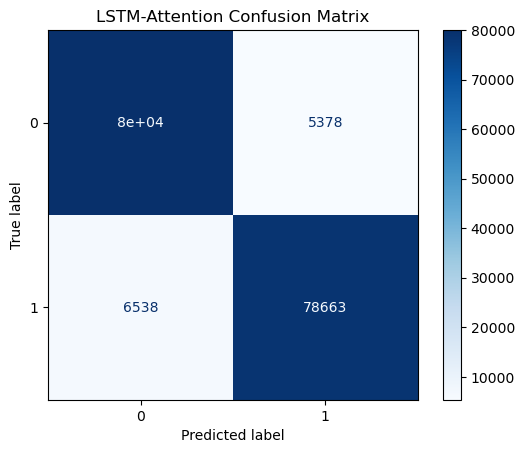

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(cmap='Blues')
plt.title('LSTM-Attention Confusion Matrix')
plt.show()
